In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -1000 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [10]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [8]:

N = 400
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.98
ϵ = 0.3
x = [20, 60, 90, 1, 1];
λ = 0.98
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);

epochs = 5000
epochsize = 500

total = 0
rando = 0

last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
u = uu[1]
rando += uu[2]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    u = uu[1]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
        
    if (counter % epochsize == 0) || (xp[1] <= 10)
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", round(mean(totals), sigdigits=4), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current4_5.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 18.1 AVG: 9.05 Epoch: 10 -----------
--------- CURRENT: 50.0 AVG: 22.7 Epoch: 11 -----------
--------- CURRENT: -99.4 AVG: -7.825 Epoch: 12 -----------
--------- CURRENT: -979.5 AVG: -202.2 Epoch: 12 -----------
--------- CURRENT: 29.4 AVG: -163.6 Epoch: 13 -----------
--------- CURRENT: -8.5 AVG: -141.4 Epoch: 14 -----------
--------- CURRENT: 50.0 AVG: -117.5 Epoch: 15 -----------
--------- CURRENT: 48.5 AVG: -99.04 Epoch: 16 -----------
--------- CURRENT: 50.0 AVG: -84.14 Epoch: 17 -----------
--------- CURRENT: 50.0 AVG: -71.95 Epoch: 18 -----------
--------- CURRENT: 50.0 AVG: -61.78 Epoch: 19 -----------
--------- CURRENT: 50.0 AVG: -53.18 Epoch: 20 -----------
--------- CURRENT: 50.0 AVG: -45.81 Epoch: 21 -----------
--------- CURRENT: -28.9 AVG: -44.69 Epoch: 22 -----------
--------- CURRENT: 12.8 AVG: -41.09 Epoch: 23 -----------
--------- CURRENT: 50.0 AVG: -35.74 Epoch: 24 -----------
--------- CURRENT: 48.8 AVG: -31.04 Epoch: 25 -----------
--------- CURR

--------- CURRENT: -951.6 AVG: -176.8 Epoch: 272 -----------
--------- CURRENT: 1.5 AVG: -176.3 Epoch: 273 -----------
--------- CURRENT: --------- CURRENT: 45.5 AVG: -191.6 Epoch: 297 -----------
--------- CURRENT: 17.9 AVG: -191.1 Epoch: 298 -----------
--------- CURRENT: -995.8 AVG: -193.2 Epoch: 298 -----------
--------- CURRENT: 31.3 AVG: -192.6 Epoch: 299 -----------
--------- CURRENT: -996.6 AVG: -194.8 Epoch: 299 -----------
--------- CURRENT: 46.5 AVG: -194.2 Epoch: 300 -----------
--------- CURRENT: 50.0 AVG: -193.5 Epoch: 301 -----------
--------- CURRENT: -37.9 AVG: -193.1 Epoch: 302 -----------
--------- CURRENT: 50.0 AVG: -192.4 Epoch: 303 -----------
--------- CURRENT: -62.5 AVG: -192.1 Epoch: 304 -----------
--------- CURRENT: 38.3 AVG: -191.5 Epoch: 305 -----------
--------- CURRENT: -998.2 AVG: -193.6 Epoch: 305 -----------
--------- CURRENT: 5.6 AVG: -199.5 Epoch: 326 -----------
--------- CURRENT: -88.9 AVG: -199.3 Epoch: 327 -----------
--------- CURRENT: -27.7 AVG

--------- CURRENT: -27.7 AVG: -252.9 Epoch: 635 -----------
--------- CURRENT: -58.0 AVG: -252.7 Epoch: 636 -----------
--------- CURRENT: -82.0 AVG: -252.5 Epoch: 637 -----------
--------- CURRENT: -64.0 AVG: -252.2 Epoch: 638 -----------
--------- CURRENT: -982.6 AVG: -253.1 Epoch: 638 -----------
--------- CURRENT: -975.1 AVG: -254.0 Epoch: 638 -----------
--------- CURRENT: 7.5 AVG: -253.7 Epoch: 639 -----------
--------- CURRENT: 32.0 AVG: -253.3 Epoch: 640 -----------
--------- CURRENT: 15.2 AVG: -253.0 Epoch: 641 -----------
--------- CURRENT: 47.3 AVG: -252.7 Epoch: 642 -----------
--------- CURRENT: -956.9 AVG: -253.5 Epoch: 642 -----------
--------- CURRENT: 6.8 AVG: -253.2 Epoch: 643 -----------
--------- CURRENT: -17.8 AVG: -252.9 Epoch: 644 -----------
--------- CURRENT: -968.6 AVG: -253.7 Epoch: 644 -----------
--------- CURRENT: 18.5 AVG: -253.4 Epoch: 645 -----------
--------- CURRENT: -11.5 AVG: -253.1 Epoch: 646 -----------
--------- CURRENT: -65.2 AVG: -252.9 Epoch: 

--------- CURRENT: 29.9 AVG: -261.8 Epoch: 728 -----------
--------- CURRENT: -969.6 AVG: -262.5 Epoch: 728 -----------
--------- CURRENT: -984.1 AVG: -263.3 Epoch: 728 -----------
--------- CURRENT: 3.5 AVG: -263.0 Epoch: 729 -----------
--------- CURRENT: 39.8 AVG: -262.7 Epoch: 730 -----------
--------- CURRENT: 49.1 AVG: -262.4 Epoch: 731 -----------
--------- CURRENT: 16.4 AVG: -262.1 Epoch: 732 -----------
--------- CURRENT: 44.0 AVG: -261.8 Epoch: 733 -----------
--------- CURRENT: -976.5 AVG: -262.5 Epoch: 733 -----------
--------- CURRENT: 1.5 AVG: -262.2 Epoch: 734 -----------
--------- CURRENT: -998.1 AVG: -263.0 Epoch: 734 -----------
--------- CURRENT: -22.2 AVG: -262.7 Epoch: 735 -----------
--------- CURRENT: 33.2 AVG: -262.4 Epoch: 736 -----------
--------- CURRENT: 0.2 AVG: -262.2 Epoch: 737 -----------
--------- CURRENT: -975.6 AVG: -262.9 Epoch: 737 -----------
--------- CURRENT: 25.5 AVG: -262.6 Epoch: 738 -----------
--------- CURRENT: 33.2 AVG: -262.3 Epoch: 739 -

--------- CURRENT: 41.6 AVG: -265.6 Epoch: 823 -----------
--------- CURRENT: 44.3 AVG: -265.3 Epoch: 824 -----------
--------- CURRENT: -78.1 AVG: -265.2 Epoch: 825 -----------
--------- CURRENT: 50.0 AVG: -264.9 Epoch: 826 -----------
--------- CURRENT: -987.1 AVG: -265.5 Epoch: 826 -----------
--------- CURRENT: 7.9 AVG: -265.3 Epoch: 827 -----------
--------- CURRENT: 50.0 AVG: -265.0 Epoch: 828 -----------
--------- CURRENT: 23.3 AVG: -264.7 Epoch: 829 -----------
--------- CURRENT: -18.4 AVG: -264.5 Epoch: 830 -----------
--------- CURRENT: 34.4 AVG: -264.3 Epoch: 831 -----------
--------- CURRENT: 31.4 AVG: -264.0 Epoch: 832 -----------
--------- CURRENT: 4.1 AVG: -263.8 Epoch: 833 -----------
--------- CURRENT: -16.3 AVG: -263.5 Epoch: 834 -----------
--------- CURRENT: 31.4 AVG: -263.3 Epoch: 835 -----------
--------- CURRENT: -985.9 AVG: -263.9 Epoch: 835 -----------
--------- CURRENT: 15.7 AVG: -263.7 Epoch: 836 -----------
--------- CURRENT: 42.5 AVG: -263.4 Epoch: 837 ----

In [ ]:
#transpose(θ[:,2])*ξ

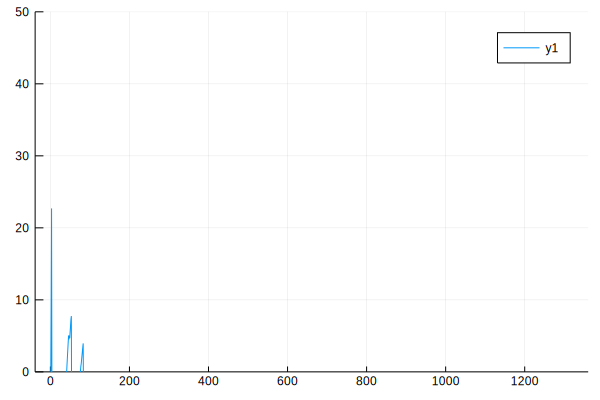

In [12]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (0,50))

In [ ]:
thetaframe = CSV.read("0.44_theta_12.1_1.csv")


In [ ]:
θ = convert(Matrix, thetaframe)

In [ ]:
thetaframe = DataFrame(θ)
CSV.write("0.44_theta_11.28_1", thetaframe)

In [ ]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)
